In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.sparse.linalg import svds
from IPython.display import display

## Setup

We have a matrix of films, such that each row is a vector holding the metadata for a film. Each film vector is organized as follows: [genre1, genre2, ..., genreN, quality], such that the first NUM_GENRES columns hold how aligned the film is with each genre, and the last column holds the film's quality, which dictates the mean rating for the film. The genre alignment values are all between 0 and 1, and sum to 1.

The user matrix is organized analogously, with each row holding the metdata for the user, in the format: [pref1, pref2, ..., prefN, behavior]. The NUM_GENRES columns hold how much a user likes a particular genre, and the last column holds the user's behavior, which determines how the user will react to recommended videos. Similarly, the preference values are all between 0 and 1, and sum to 1.

In [2]:
########################################
#          SIMULATOR SETTINGS
########################################

# Total number of films and users
NUM_USERS = 2000 # 6040
NUM_FILMS = 1300 # 3883

# Total number of film genres
NUM_GENRES = 2

# Maximum film rating (e.g. 5 uses the rating scale 0-5)
MAX_RATING = 5

# Higher values = stronger user genre preferences
# Use higher values with higher NUM_GENRES values
# Reasonable values are probably b/w 0.1 and 10
USER_POLARIZATION_STRENGTH = 0.5
FILM_POLARIZATION_STRENGTH = 0.5

# A film is considered "polarized" if its highest
# film genre value is above this threshold
POLARIZED_FILM_THRESHOLD = 0.7

# Percentage of films users will initially watch
INITIAL_VIEWING_RATE = 0.05

# Whether to rescale the initial ratings such that
# mean rating is equal the half the maximum rating
RESCALE_TO_MIDLINE = True

# If True, users will always watch all recommended films
ALWAYS_WATCH = False

# A user's "behavior" determines how a user chooses
# which video(s) to watch at each simulation step
# NAMES is a one-word description of each behavior,
# and DISTRIBUTION determines the ratio of behaviors
# among the created users
BEHAVIOR_PROP_IDX = NUM_GENRES
BEHAVIOR_NAMES = ['follower', 'stubborn', 'mixed']
BEHAVIOR_DISTRIBUTION = [1, 1, 1]

# If False, all users watch recommended films with
# probability equal to their compatibility with it
USE_BEHAVIOR = False

# A film's "quality" determines the mean rating
# of the film, and is used as the baseline which
# user preferences modify to get the final rating
QUALITY_PROP_IDX = NUM_GENRES
QUALITY_MIN = MAX_RATING / 4.0
QUALITY_MAX = 3 * MAX_RATING / 4.0

# If False, the average film rating is used as the
# baseline when calculating new ratings instead
USE_QUALITY = True

# Specify the recommender system to use
AVAILABLE_RECOMMENDER_MODELS = ['svd', 'popularity', 'random']
RECOMMENDER_MODEL = 'svd'

# Number of films to recommend at each step
NUM_RECS = 5

# The number of singular values to compute with SVD
# Larger values give more accurate predictions, but
# take longer to compute (and give longer simulator
# convergence times)
# Reasonable values are probably b/w 10 and 50
K_VAL = 50

# Determines how much a user's compatibility with 
# the film affects the final rating. The final
# rating given will be mean_film_rating + x,
# where -CRS <= x <= CRS
COMPATIBILITY_RATING_STRENGTH = 3

# Specify the anti-filter-bubble system to use
AVAILABLE_ANTI_BUBBLE_SYSTEMS = ['none', 'random', 'discovery']
ANTI_BUBBLE_SYSTEM = 'none'

# Determines how much randomness the recommender will
# introduce in order to prevent filter bubbles. The
# final recommendation strength will be the predicted
# rating + x, where -ABS <= x <= ABS
RECOMMENDER_RANDOMNESS = 1.0

# User Discovery Factor. 0 means that user does not want 
# to be recommended items of the opposing view.
# 1 means that user really wants to be recommended 
# items of the opposing view
# If an item's rating is greater than or equal to 4,
# subtract USER_DISCOVERY_FACTOR * mean_rating from that rating
# If an item's rating is less than or equal to 2, subtract
# add USER_DISCOVERY_FACTOR * mean_rating to that rating
USER_DISCOVERY_FACTOR = 0.8

# Probability of a follower watching a recommended film
FOLLOWER_VIEW_RATE = 0.5

# Minimum compatibility a stubborn user must
# have with a film in order to watch it
STUBBORN_COMPATIBILITY_THRESHOLD = 0.8

# How much watched films are penalized over unwatched
# ones when making recommendations, and when the users
# are choosing which videos to watch respectively
# (Effect is multiplicative: should be b/w 0 and 1)
REWATCH_RECOMMENDATION_PENALTY = 0.5
REWATCH_VIEW_PENALTY = 0.5

# The maximum steps to run the simulation for
MAX_STEPS = 100

# The maximum number of distribution changes allowed
# within a simulator step before its considered "converged"
CHANGE_THRESHOLD = 0

# Validate and standardize the behavior configuration parameters
if len(BEHAVIOR_NAMES) != len(BEHAVIOR_DISTRIBUTION):
    raise ValueError("BEHAVIOR_NAMES and BEHAVIOR_DISTRIBUTION "
            "must have the same length.")
BEHAVIOR_NAMES = np.array(BEHAVIOR_NAMES)
BEHAVIOR_DISTRIBUTION = np.array(BEHAVIOR_DISTRIBUTION) / float(sum(BEHAVIOR_DISTRIBUTION))

# Validate the model and ABS configuration parameters
if RECOMMENDER_MODEL not in AVAILABLE_RECOMMENDER_MODELS:
    raise ValueError("RECOMMENDER_MODEL must be a value in AVAILABLE_RECOMMENDER_MODELS.")
if ANTI_BUBBLE_SYSTEM not in AVAILABLE_ANTI_BUBBLE_SYSTEMS:
    raise ValueError("ANTI_BUBBLE_SYSTEM must be a value in AVAILABLE_ANTI_BUBBLE_SYSTEMS.")

In [3]:
def generate_users(number_of_users):
    """
    Generate a user matrix, where each row of the
    matrix stores the properties of a user:
    [genre1_preference, ..., genreN_preference, behavior]
    
    The genre preferences of each user sum to 1.
    behavior will be an integer b/w 0 and num_behaviors
    """
    results = []
    for i in range(number_of_users):
        user_prefs = np.random.dirichlet(
                np.ones(NUM_GENRES)/USER_POLARIZATION_STRENGTH, size=1)[0]
        behavior = np.random.choice(np.arange(len(BEHAVIOR_NAMES)),
                p=BEHAVIOR_DISTRIBUTION)
        user_props = np.append(user_prefs, behavior)
        results.append(user_props)
    return np.array(results)

def generate_films(number_of_films):
    """
    Generate a film matrix, where each row of the
    matrix represents the properties of a film:
    [genre1, ..., genreN, quality]
    
    The genre values of each film sum to 1.
    quality will be b/w QUALITY_MIN and QUALITY_MAX.
    """
    results = []
    for i in range(number_of_films):
        film_genres = np.random.dirichlet(
                np.ones(NUM_GENRES)/FILM_POLARIZATION_STRENGTH, size=1)[0]
        quality = random.uniform(QUALITY_MIN, QUALITY_MAX)
        film_props = np.append(film_genres, quality)
        results.append(film_props)
    return np.array(results)

In [4]:
def divide_film_users_cat(films_or_users):
    """
    Given a film, [genre1, genre2], or a user, [genre1, genre2], and divide 
    the film or user into extreme genre1, mild genre1, neutral, mild genre2,
    extreme genre 2.
    Returns cat, which is the category each film belongs to.
    Returns film_num, which is the number of films in each category.
    -2 -> radical genre 1
    -1 -> mild genre 1
    0 -> neutral
    1 -> mild genre 2
    2 -> radical genre 2
    """
    cat = []
    film_num = []
    for film_or_user in films_or_users:
        if film_or_user[0] > film_or_user[1]:
            if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
                cat.append(0)
            elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
                cat.append(-1)
            else:
                cat.append(-2)
        else:
            if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
                cat.append(0)
            elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
                cat.append(1)
            else:
                cat.append(2)
    extreme1 = np.sum((np.array(cat) == -2).astype(int))
    mild1 = np.sum((np.array(cat) == -1).astype(int))
    neutral = np.sum((np.array(cat) == 0).astype(int))
    mild2 = np.sum((np.array(cat) == 1).astype(int))
    extreme2 = np.sum((np.array(cat) == 2).astype(int))
    film_num.append(extreme1)
    film_num.append(mild1)
    film_num.append(neutral)
    film_num.append(mild2)
    film_num.append(extreme2)
    return cat, film_num          

In [5]:
def film_users_cat(film_or_user):
    """
    Given a film, [genre1, genre2], or a user, [genre1, genre2], and divide 
    the film or user into extreme genre1, mild genre1, neutral, mild genre2,
    extreme genre 2.
    Return cat, which is the category each film or user belongs to.
    -2 -> radical genre 1
    -1 -> mild genre 1
    0 -> neutral
    1 -> mild genre 2
    2 -> radical genre 2
    """
    cat = 0
    if film_or_user[0] > film_or_user[1]:
        if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
            cat = 0
        elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
            cat = -1
        else:
            cat = -2 
    else:
        if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
            cat = 0
        elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
            cat = 1
        else:
            cat = 2
    return cat

In [6]:
users = generate_users(NUM_USERS)
films = generate_films(NUM_FILMS)

display(users)
print(users.shape)
display(films)
print(films.shape)

array([[0.26956792, 0.73043208, 0.        ],
       [0.80184493, 0.19815507, 2.        ],
       [0.97186452, 0.02813548, 0.        ],
       ...,
       [0.3530437 , 0.6469563 , 0.        ],
       [0.515274  , 0.484726  , 0.        ],
       [0.5542788 , 0.4457212 , 1.        ]])

(2000, 3)


array([[0.01700052, 0.98299948, 2.23576633],
       [0.2272558 , 0.7727442 , 3.69890477],
       [0.87007956, 0.12992044, 1.91318922],
       ...,
       [0.21877332, 0.78122668, 2.64241786],
       [0.75044716, 0.24955284, 1.96456485],
       [0.84307371, 0.15692629, 1.94933236]])

(1300, 3)


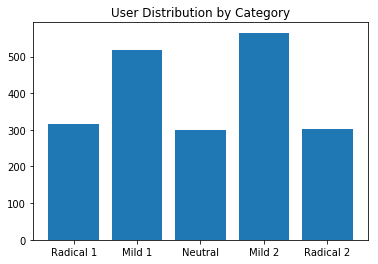

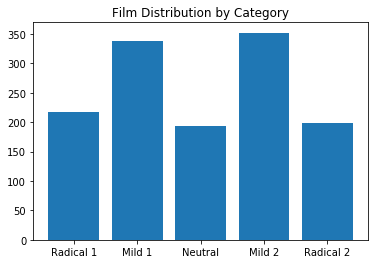

In [7]:
CATEGORY_NAMES = ["Radical 1", "Mild 1", "Neutral", "Mild 2", "Radical 2"]

def get_categories(users_or_films):
    return [film_users_cat(x) for x in users_or_films]

def get_categorical_distribution(categories):
    results = []
    for category in range(-2, 3):
        num_of_category = len([x for x in categories if x == category])
        category_name = CATEGORY_NAMES[category + 2]
        results.append(num_of_category)
    return results

def plot_categorical_distribution(cat_distribution, title):
    plt.bar(range(len(CATEGORY_NAMES)), cat_distribution)
    plt.xticks(range(len(CATEGORY_NAMES)), CATEGORY_NAMES)
    plt.title(title)
    plt.show()

# Get the categories and categorical distribution of the users and films
user_categories = get_categories(users)
film_categories = get_categories(films)
user_cat_distribution = get_categorical_distribution(user_categories)
film_cat_distribution = get_categorical_distribution(film_categories)

# Plot the categorical distribution of the users andfilms
plot_categorical_distribution(user_cat_distribution, "User Distribution by Category")
plot_categorical_distribution(film_cat_distribution, "Film Distribution by Category")

In [8]:
def get_user_film_compatibility(userID, filmID):
    """
    Returns a value between 0 and 1 indicating how much
    a user's preferences aligns with the film's genre(s).
    """
    user_prefs = users[userID][:NUM_GENRES]
    film_genres = films[filmID][:NUM_GENRES]
    return 1 - (np.sum(np.abs(user_prefs - film_genres)) / NUM_GENRES)

# Compute the compatabilities of a random sample of users
# and films, so some stats can be calcuated on them
compats = []
sample_userIDs = random.sample(list(np.arange(NUM_USERS)), min(500, NUM_USERS))
sample_filmIDs = random.sample(list(np.arange(NUM_FILMS)), min(500, NUM_FILMS))
for userID in sample_userIDs:
    for filmID in sample_filmIDs:
        compats.append(get_user_film_compatibility(userID, filmID))

mean_compatibility = 1.0 * sum(compats) / len(compats)
max_abs_compatibility = max(max(compats), abs(min(compats)))

print("Mean compatibility: %f" % mean_compatibility)
print("Max absolute compatibility: %f" % max_abs_compatibility)

Mean compatibility: 0.740708
Max absolute compatibility: 1.000000


In [9]:
def get_user_film_rating(userID, filmID, actual_ratings=None, is_initial_rating=False):
    """
    Returns a value between 0 and MAX_RATING indicating the
    rating the user would give the film upon watching it.
    
    actual_ratings must be provided when USE_QUALITY and
    is_initial_rating is False, so the current mean rating
    of the film can be calculated.
    
    is_initial_rating should be set True when generating the
    starting ratings for the film.
    """
    compatibility = get_user_film_compatibility(userID, filmID)
    
    if USE_QUALITY:
        base_rating = films[filmID][QUALITY_PROP_IDX]
    else:
        if is_initial_rating:
            return round(MAX_RATING * compatibility)
        else:
            film_ratings = actual_ratings[:, filmID]
            base_rating = np.mean(film_ratings[film_ratings.nonzero()])

    # Convert compatibility to a value within [-CRS, +CRS]
    compat_influence = ((compatibility - mean_compatibility)
            / max_abs_compatibility) * COMPATIBILITY_RATING_STRENGTH
    return max(min(round(base_rating + compat_influence), MAX_RATING), 0)

def generate_initial_ratings(users, films, view_rate, rescale_to_midline=False):
    """
    Generates a (num_films, num_users) rating matrix, where
    each row represents the ratings that film has received
    from all users.
    
    view_rate is the chance a user will view a given film.
    
    If rescale_to_midline is True, the ratings are scaled
    such that mean of non-zero ratings is MAX_RATING / 2.
    """
    results = []
    for userID in range(users.shape[0]):
        user_ratings = []
        for filmID in range(films.shape[0]):
            ran = random.uniform(0,1)
            if (ran <= view_rate):
                rating = get_user_film_rating(userID, filmID, is_initial_rating=True)
                user_ratings.append(rating)
            else:
                user_ratings.append(0)
        results.append(user_ratings)
    results = np.array(results)
    # Perform rescaling if necessary
    if rescale_to_midline:
        results = results * ((MAX_RATING / 2.0) / (results[results.nonzero()].mean()))
        results = np.clip(np.round(results), 0, MAX_RATING)
    return results

In [10]:
initial_ratings = generate_initial_ratings(users, films,
        INITIAL_VIEWING_RATE, rescale_to_midline=RESCALE_TO_MIDLINE)

display(initial_ratings)
print(initial_ratings.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(2000, 1300)


In [11]:
def get_predicted_ratings(actual_ratings):
    """
    Returns a (num_users, num_films) matrix containing
    the predicted ratings each user would each film.
    """
    ratings = actual_ratings
    
    # If specified, move polarized ratings closer to the median
    # so users can discover content that disagrees with their prefs
    if ANTI_BUBBLE_SYSTEM == 'discovery':
        ratings = np.copy(actual_ratings)
        mask1 = (ratings > 0) & (ratings <= 2)
        mask2 = (ratings >= 4)
        ratings = ratings.astype(float)
        ratings[mask1] = ratings[mask1] + USER_DISCOVERY_FACTOR * np.mean(ratings)
        ratings[mask2] = ratings[mask2] - USER_DISCOVERY_FACTOR * np.mean(ratings)
    
    if RECOMMENDER_MODEL == 'svd':
        # Only consider non-zero ratings when calculating the mean
        masked_user_ratings = np.ma.masked_equal(ratings, 0)
        user_ratings_mean = masked_user_ratings.mean(axis=1).data
        # Calculate SVD values of demeaned ratings + estimate new ratings
        R_demeaned = ratings - user_ratings_mean.reshape(-1, 1)
        U, sigma, Vt = svds(R_demeaned, k=K_VAL)
        sigma = np.diag(sigma)
        predicted_ratings = np.round(np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1))
        return predicted_ratings
    
    elif RECOMMENDER_MODEL == 'popularity':
        # IMDB weighted ratings for popularity-based 
        # recommendation system: (v/(v+m) * R) + (m/(v+m) * C)
        # v : number of ratings
        # m : minimum votes required
        # R : average ratings of film
        # C : mean ratings of whole report
        v = np.count_nonzero(ratings, axis=0)
        popularity_ratings = pd.DataFrame(v)
        m = popularity_ratings.quantile(0.90)
        m = m.values[0]
        R = pd.DataFrame(ratings).replace(0, np.nan)
        R = R.mean(axis=0)
        C = R.mean()
        popularity_map = (v / (v + m) * R) + (m / (v + m) * C)
        popularity_ratings = pd.DataFrame(ratings).replace(0, np.nan)
        popularity_ratings = popularity_ratings.fillna(popularity_map)
        return popularity_ratings.values
        
    elif RECOMMENDER_MODEL == 'random':
        random_ratings = pd.DataFrame(ratings).replace(0, np.nan)
        random_idx = random_ratings.isnull()
        random_ratings[random_idx] = np.random.uniform(1, 5,
                (users.shape[0], films.shape[0]))
        return random_ratings.values

example_predictions = get_predicted_ratings(initial_ratings)
display(example_predictions)
print(example_predictions.shape)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0.,  1.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., -0.,  0., ..., -0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.]])

(2000, 1300)


In [12]:
def get_recommendations(actual_ratings, predicted_ratings, userID, num_recommendations=NUM_RECS):
    """
    Gets the top num_recommendations film recommendations for
    the provided user, using the rating prediction matrix, and
    returns a tuple containing the recommended film IDs, and
    counts of the recommendations received of each film genre.
    Returns (None, []) if no films can be recommended.
    """
    # Get predicted user ratings + films that were already watched
    predicted_user_ratings = predicted_ratings[userID]
    watched_films = np.apply_along_axis(lambda x: x != 0, 0, actual_ratings[userID])
    # If there are no films that can be recommended, return None
    if np.sum(watched_films) == watched_films.shape[0]:
        return (None, [])
    # Penalize already watched films
    watched_penalty = watched_films * REWATCH_RECOMMENDATION_PENALTY
    watched_penalty[watched_films == 0] = 1.0
    recommendation_matrix = predicted_user_ratings * watched_penalty
    # Add some amount of randomness to the recommendations,
    # according to how much we want to prevent filter bubbles
    if ANTI_BUBBLE_SYSTEM == "random":
        anti_bubble_matrix = (np.random.random(films.shape[0]) - 0.5) * \
                2.0 * RECOMMENDER_RANDOMNESS
        recommendation_matrix += anti_bubble_matrix
    # Get the film recommendations + the genre distribution
    recommended_filmIDs = np.argsort(recommendation_matrix)\
            [-num_recommendations:].tolist()
    film_recs = films[recommended_filmIDs, :]
    genre_counts = [int(round(sum(film_recs[:, genre_idx])))
            for genre_idx in range(NUM_GENRES)]
    return (recommended_filmIDs, genre_counts)

example_recs = get_recommendations(initial_ratings, example_predictions, 0)
print("Example Film Recommendations: " + str(example_recs[0]))
print("Example Distribution: " + str(example_recs[1]))

Example Film Recommendations: [539, 1185, 1173, 625, 687]
Example Distribution: [2, 3]


In [13]:
def give_recommendation(userID, filmID, actual_ratings):
    """
    Actually gives a film recommendation to a user, and
    determines whether the user will watch it, based on
    their behavior, and returns the rating if so.
    Returns None if the user does not watch the film.
    """
    behavior_name = BEHAVIOR_NAMES[int(users[userID][BEHAVIOR_PROP_IDX])]
    compatibility = get_user_film_compatibility(userID, filmID)
    ran = random.uniform(0, 1)
    
    # Follower: watches any of the recommended films with equal weight 
    if behavior_name == "follower":
        does_watch = ran <= FOLLOWER_VIEW_RATE
    # Mixed: watches a recommended video with probability
    # equal to their compatability with that film
    elif behavior_name == "mixed":
        does_watch = ran <= compatibility
    # Stubborn: only watches videos above a certain compatibility threshold
    elif behavior_name == "stubborn":
        does_watch = compatibility <= STUBBORN_COMPATIBILITY_THRESHOLD
    else:
        raise ValueError("Programmer Error: Unexpected behavior value '%d'" % behavior)
    
    # If the user would be rewatching the film, change their
    # mind with some probability, according to the rewatch penalty
    if does_watch and actual_ratings[userID][filmID] != 0:
        ran2 = random.uniform(0, 1)
        does_watch = ran2 <= REWATCH_VIEW_PENALTY
        
    if does_watch:
        return get_user_film_rating(userID, filmID, actual_ratings)
    else:
        return None

## Run Simulator

In [14]:
initial_predictions = get_predicted_ratings(initial_ratings)

# A (num_users, num_genres) matrix where each row
# is the number of recommendations that user has
# received of each film genre
initial_distribution_matrix = []

# Get the initial recommendation genre distribution
for userID in range(users.shape[0]):
    (recommended_filmIDs, type_counts) = get_recommendations(initial_ratings, initial_predictions, userID)
    initial_distribution_matrix.append(type_counts)

display(initial_distribution_matrix[:10])

[[2, 3],
 [3, 2],
 [3, 2],
 [2, 3],
 [3, 2],
 [3, 2],
 [2, 3],
 [2, 3],
 [3, 2],
 [2, 3]]

In [15]:
def step_simulation(actual_ratings, predicted_ratings, rec_genre_counts,
                    prev_user_satisfaction_vector):
    """
    Runs one step of the simulation:
    
    Gives new recommendations to each user, and simulates them
    viewing + rating a random selection of them.
    
    Returns the new rating matrix, the new distribution matrix of
    recommended film genres, the # of changes in this matrix, a
    vector of all recommended film IDs, the user satisfaction
    vector, and the filter bubble measurement vectors.
    """
    new_ratings = actual_ratings.copy()
    new_distribution_matrix = []
    num_distribution_changes = 0
    all_recommended_filmIDs = np.zeros([users.shape[0], NUM_RECS])
    user_satisfaction_vector = np.zeros([users.shape[0]])
    ideological_isolation_vector = np.zeros([users.shape[0]])
    categorical_disparity_vector = np.zeros([users.shape[0]])
    
    for userID in range(users.shape[0]):
        user = users[userID]
        (recommended_filmIDs, new_genre_counts) = \
                get_recommendations(new_ratings, predicted_ratings, userID)
        if recommended_filmIDs is None:
            raise ValueError("Ran out of films.")
        new_distribution_matrix.append(new_genre_counts)
        all_recommended_filmIDs[userID] = recommended_filmIDs
        
        # Check for changes in the user's recommendation distribution
        if (new_genre_counts[0] != rec_genre_counts[userID][0]) or \
                (new_genre_counts[1] != rec_genre_counts[userID][1]):
            num_distribution_changes += 1
        
        # Determine whether the user will watch each
        # recommended film, and assign a rating if so
        user_ratings = []
        for i, filmID in enumerate(recommended_filmIDs):
            rating = None
            if ALWAYS_WATCH:
                rating = get_user_film_rating(userID, filmID, actual_ratings)
            elif USE_BEHAVIOR:
                rating = give_recommendation(userID, filmID, actual_ratings)
            else:
                compatibility = get_user_film_compatibility(userID, filmID)
                has_watched = actual_ratings[userID][filmID] != 0
                ran = random.uniform(0,1)
                if ran <= compatibility * (REWATCH_VIEW_PENALTY if has_watched else 1.0):
                    rating = get_user_film_rating(userID, filmID, actual_ratings)
            if rating is not None:
                new_ratings[userID, filmID] = rating
                user_ratings.append(rating)
        
        # Determine the user's satisfaction with this step's recommendations
        # If the user did not watch any videos, use the previous satisfaction
        user_satisfaction_vector[userID] = np.mean(user_ratings) \
                if len(user_ratings) > 0 else prev_user_satisfaction_vector[userID]
        
        # Determine the filter bubble meaurement vectors with this step's recommendations
        ideological_isolation_vector[userID] = np.mean([1 - (np.sum(np.abs(
                users[userID][:NUM_GENRES] - films[filmID][:NUM_GENRES])))
                for filmID in recommended_filmIDs])
        categorical_disparity_vector[userID] = np.std([film_categories[filmID]
                for filmID in recommended_filmIDs]) / 2.0
    
    return (new_ratings, new_distribution_matrix, num_distribution_changes,
            all_recommended_filmIDs, user_satisfaction_vector,
            ideological_isolation_vector, categorical_disparity_vector)

In [16]:
ratings = initial_ratings.copy()
predictions = initial_predictions.copy()
rec_distribution = list(initial_distribution_matrix)
user_satisfaction = np.zeros(users.shape[0])
num_changes_over_time = []
recommended_filmIDs_over_time = []
user_satisfaction_over_time = []
ideological_isolation_over_time = []
categorical_disparity_over_time = []

for step in range(MAX_STEPS):
    predictions = get_predicted_ratings(ratings)
    ratings, rec_distribution, num_changes, recommended_filmIDs, \
            user_satisfaction, ideological_isolation, categorical_disparity = \
            step_simulation(ratings, predictions, rec_distribution, user_satisfaction)
    num_changes_over_time.append(num_changes)
    recommended_filmIDs_over_time.append(recommended_filmIDs)
    user_satisfaction_over_time.append(user_satisfaction)
    ideological_isolation_over_time.append(ideological_isolation)
    categorical_disparity_over_time.append(categorical_disparity)
    if step > 0 and num_changes <= CHANGE_THRESHOLD:
        print("Convergence!")
        break
    print("Step #%d: Num Changes = %d" % (step, num_changes))
    if step == MAX_STEPS-1:
        print("Max simulation steps reached.")

Step #0: Num Changes = 0
Step #1: Num Changes = 910
Step #2: Num Changes = 733
Step #3: Num Changes = 608
Step #4: Num Changes = 476
Step #5: Num Changes = 427
Step #6: Num Changes = 396
Step #7: Num Changes = 400
Step #8: Num Changes = 376
Step #9: Num Changes = 337
Step #10: Num Changes = 352
Step #11: Num Changes = 332
Step #12: Num Changes = 327
Step #13: Num Changes = 323
Step #14: Num Changes = 368
Step #15: Num Changes = 322
Step #16: Num Changes = 326
Step #17: Num Changes = 335
Step #18: Num Changes = 320
Step #19: Num Changes = 313
Step #20: Num Changes = 290
Step #21: Num Changes = 307
Step #22: Num Changes = 283
Step #23: Num Changes = 279
Step #24: Num Changes = 280
Step #25: Num Changes = 303
Step #26: Num Changes = 283
Step #27: Num Changes = 301
Step #28: Num Changes = 272
Step #29: Num Changes = 263
Step #30: Num Changes = 299
Step #31: Num Changes = 266
Step #32: Num Changes = 284
Step #33: Num Changes = 275
Step #34: Num Changes = 274
Step #35: Num Changes = 254
Step

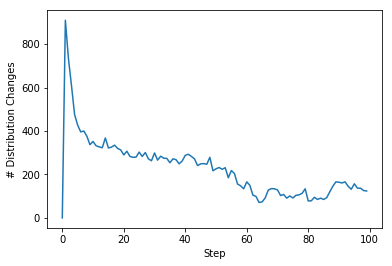

In [17]:
# Plot the recommendation distribution changes over time
plt.plot(num_changes_over_time)
plt.xlabel("Step")
plt.ylabel("# Distribution Changes")
plt.show()

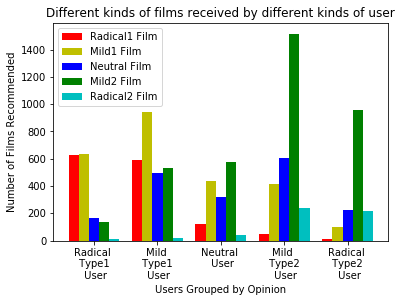

In [18]:
def plot_filter_bubble(final_rec):
    radical1 = np.int_([0,0,0,0,0])
    mild1 = np.int_([0,0,0,0,0])
    neutral = np.int_([0,0,0,0,0])
    mild2 = np.int_([0,0,0,0,0])
    radical2 = np.int_([0,0,0,0,0])
    for i in range(0,final_rec.shape[0]):
        user = users[i]
        curr_rec = final_rec[i]
        rec_films = films[curr_rec]
        user_cat = film_users_cat(user)
        _,dist = divide_film_users_cat(rec_films)
        if user_cat == -2:
            radical1 += dist
        elif user_cat == -1:
            mild1 += dist
        elif user_cat == 0:
            neutral += dist
        elif user_cat == 1:
            mild2 += dist
        else:
            radical2 += dist
    N = 5

    radical1_film = np.int_([0,0,0,0,0])
    mild1_film = np.int_([0,0,0,0,0])
    neutral_film = np.int_([0,0,0,0,0])
    mild2_film = np.int_([0,0,0,0,0])
    radical2_film = np.int_([0,0,0,0,0])

    radical1_film[0] = radical1[0]
    radical1_film[1] = mild1[0]
    radical1_film[2] = neutral[0]
    radical1_film[3] = mild2[0]
    radical1_film[4] = radical2[0]

    mild1_film[0] = radical1[1]
    mild1_film[1] = mild1[1]
    mild1_film[2] = neutral[1]
    mild1_film[3] = mild2[1]
    mild1_film[4] = radical2[1]

    neutral_film[0] = radical1[2]
    neutral_film[1] = mild1[2]
    neutral_film[2] = neutral[2]
    neutral_film[3] = mild2[2]
    neutral_film[4] = radical2[2]

    mild2_film[0] = radical1[3]
    mild2_film[1] = mild1[3]
    mild2_film[2] = neutral[3]
    mild2_film[3] = mild2[3]
    mild2_film[4] = radical2[3]

    radical2_film[0] = radical1[4]
    radical2_film[1] = mild1[4]
    radical2_film[2] = neutral[4]
    radical2_film[3] = mild2[4]
    radical2_film[4] = radical2[4]

    ind = np.arange(N)  # the x locations for the groups
    width = 0.16        # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, radical1_film, width, color='r')
    rects2 = ax.bar(ind + width, mild1_film, width, color='y')
    rects3 = ax.bar(ind + 2 * width, neutral_film, width, color='b')
    rects4 = ax.bar(ind + 3 * width, mild2_film, width, color='g')
    rects5 = ax.bar(ind + 4 * width, radical2_film, width, color='c')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Films Recommended')
    ax.set_xlabel('Users Grouped by Opinion')
    ax.set_title('Different kinds of films received by different kinds of user')
    ax.set_xticks(ind + width * 2)
    ax.set_xticklabels(('Radical \n Type1 \n User', 'Mild \n Type1 \n User', 'Neutral \n User', 'Mild \n Type2 \n User', 'Radical \n Type2 \n User'))
    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0],rects5[0]), ('Radical1 Film', 'Mild1 Film', 'Neutral Film',
                                                                      'Mild2 Film', 'Radical2 Film'))

rec = np.int_(recommended_filmIDs_over_time)[-1]
plot_filter_bubble(rec)

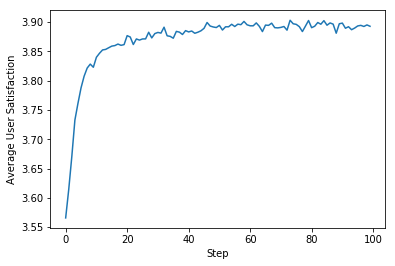

In [19]:
# Plot the average user satisfaction over time
avg_user_satisfaction_over_time = [np.mean(x) for x in user_satisfaction_over_time]
plt.plot(avg_user_satisfaction_over_time)
plt.xlabel("Step")
plt.ylabel("Average User Satisfaction")
plt.show()

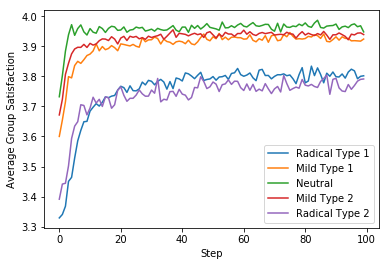

In [20]:
# Plot the satisfaction over time for each user group
for cat in range(-2, 3):
    group_satisfaction_over_time = [
        np.mean([x for i,x in enumerate(user_satisfaction) if user_categories[i] == cat])
        for user_satisfaction in user_satisfaction_over_time
    ]
    label = ["Radical Type 1", "Mild Type 1", "Neutral", "Mild Type 2", "Radical Type 2"][cat+2]
    plt.plot(group_satisfaction_over_time, label=label)
plt.xlabel("Step")
plt.ylabel("Average Group Satisfaction")
plt.legend()
plt.show()

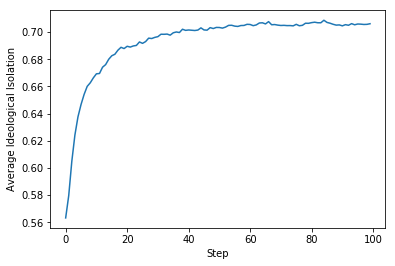

In [21]:
# Plot the average ideological isolation over time
avg_ideological_isolation_over_time = [np.mean(x) for x in ideological_isolation_over_time]
plt.plot(avg_ideological_isolation_over_time)
plt.xlabel("Step")
plt.ylabel("Average Ideological Isolation")
plt.show()

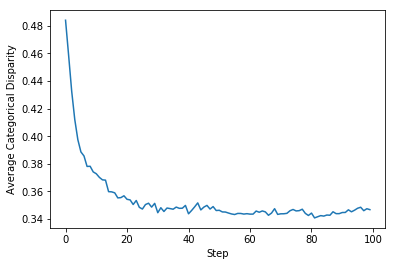

In [22]:
# Plot the average categorical disparity over time
avg_categorical_disparity_over_time = [np.mean(x) for x in categorical_disparity_over_time]
plt.plot(avg_categorical_disparity_over_time)
plt.xlabel("Step")
plt.ylabel("Average Categorical Disparity")
plt.show()

In [23]:
# NUM_STEPS x (NUM_USERS * NUM_RECS) matrix of recommended filmIDs
flattened_rec_filmIDs_over_time = np.array([x.flatten() for x in recommended_filmIDs_over_time])
# NUM_STEPS x (NUM_USERS * NUM_RECS) x NUM_GENRES matrix of recommeneded film genre values
flattened_rec_film_genres_over_time = np.array([
    [films[int(filmID)][:NUM_GENRES] for filmID in step_filmIDs]
    for step_filmIDs in flattened_rec_filmIDs_over_time
])
print(flattened_rec_filmIDs_over_time.shape)
print(flattened_rec_film_genres_over_time.shape)

(100, 10000)
(100, 10000, 2)


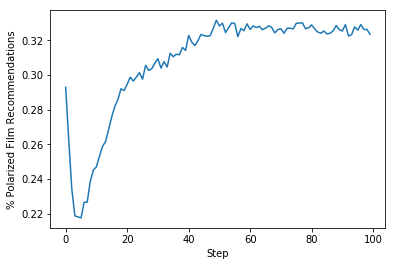

In [24]:
def get_num_polarized_recs(step_rec_film_genres):
    is_polarized = np.apply_along_axis(lambda x: max(x) > POLARIZED_FILM_THRESHOLD, 1, step_rec_film_genres)
    return sum(is_polarized) / len(step_rec_film_genres)

# Plot the percentage of recommended films that are polarized over time
percent_polarized_recs_over_time = [get_num_polarized_recs(x) for x in flattened_rec_film_genres_over_time]
plt.plot(percent_polarized_recs_over_time)
plt.xlabel("Step")
plt.ylabel("% Polarized Film Recommendations")
plt.show()

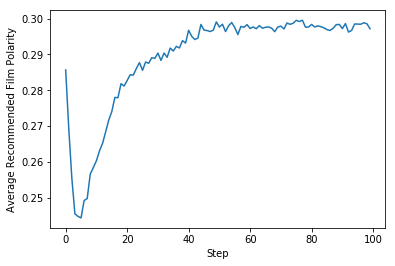

In [25]:
def get_film_polarity(film_genre_vals):
    max_val = max(film_genre_vals)
    return 1.0 * sum([max_val - val for val in film_genre_vals]) / (len(film_genre_vals) - 1)

def get_avg_film_polarity(step_rec_film_genres):
    return np.mean(np.apply_along_axis(lambda x: get_film_polarity(x), 1, step_rec_film_genres), axis=0)

# Plot the average polarity of the film recommendations over time
# Polarity is defined here as the average difference between the
# maximum genre value and the other genre values for a film
avg_rec_film_polarity_over_time = [get_avg_film_polarity(x) for x in flattened_rec_film_genres_over_time]
plt.plot(avg_rec_film_polarity_over_time)
plt.xlabel("Step")
plt.ylabel("Average Recommended Film Polarity")
plt.show()

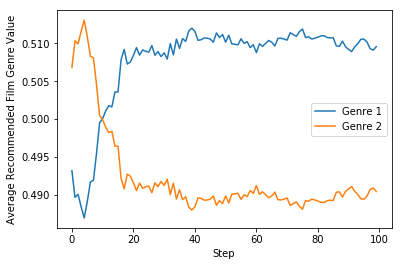

In [26]:
def get_avg_genre_values(step_rec_film_genres):
    return np.mean(step_rec_film_genres, axis=0)

# Plot the distribution of recommended film genres over time
avg_genre_values_over_time = np.array([get_avg_genre_values(x) for x in flattened_rec_film_genres_over_time])
for genre in range(NUM_GENRES):
    plt.plot(avg_genre_values_over_time[:,genre], label="Genre %d" % (genre+1))
plt.xlabel("Step")
plt.ylabel("Average Recommended Film Genre Value")
plt.legend()
plt.show()

### Observations:
Note that the higher the `COMPATIBILITY_RATING_STRENGTH`, the greater the difference between the average rating and the film quality, as expected. In general, the average rating should be higher than the film quality, because films will be recommended to users that the algorithm predicts will like it. An average rating that is lower the film quality suggests that the recommender made poor decisions when recommending that film to users.

Also note that higher quality films have more ratings, as they are recommended to more people.

In [27]:
def display_ratings_stats(filmID):
    film_quality = films[filmID][QUALITY_PROP_IDX]
    film_ratings = ratings_T[filmID]
    film_ratings = film_ratings[film_ratings.nonzero()]
    print("Film Matrix: " + str(films[filmID]))
    print("Film Quality: " + str(film_quality))
    print("Average Rating: " + str(film_ratings.mean()))
    display(film_ratings)

# Print some stats about the film ratings
ratings_T = ratings.T
mean_ratings = np.true_divide(ratings_T.sum(1),(ratings_T!=0).sum(1))
print("Sample Film\n-----------\n")
display_ratings_stats(0)
print("\n\nHighest Rated Film\n------------------\n")
display_ratings_stats(np.argmax(mean_ratings))
print("\nLowest Rated Film\n-----------------\n")
display_ratings_stats(np.argmin(mean_ratings))

Sample Film
-----------

Film Matrix: [0.01700052 0.98299948 2.23576633]
Film Quality: 2.2357663345554544
Average Rating: 1.6326530612244898


array([1., 1., 1., 2., 2., 1., 2., 2., 1., 2., 1., 2., 3., 2., 1., 1., 3.,
       2., 1., 2., 2., 1., 2., 2., 2., 1., 1., 1., 2., 1., 1., 3., 1., 1.,
       2., 2., 1., 1., 1., 1., 1., 3., 3., 1., 1., 1., 1., 2., 2., 2., 1.,
       1., 1., 3., 2., 2., 3., 1., 1., 2., 2., 2., 2., 1., 2., 2., 2., 3.,
       2., 1., 2., 1., 3., 1., 1., 1., 1., 2., 2., 1., 1., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 3., 2., 2.])



Highest Rated Film
------------------

Film Matrix: [0.46773373 0.53226627 3.7420219 ]
Film Quality: 3.74202189980557
Average Rating: 3.909090909090909


array([4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 3., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 5., 5.,
       4., 4., 4., 3., 4., 3., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.


Lowest Rated Film
-----------------

Film Matrix: [0.16677039 0.83322961 1.30381817]
Film Quality: 1.3038181716627717
Average Rating: 1.25


array([2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 1., 2., 2.,
       1., 2., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 2., 2., 1.,
       2., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [28]:
sorted_movies = np.argsort(-mean_ratings)

for i in range(10):
    display_ratings_stats(sorted_movies[i])

Film Matrix: [0.46773373 0.53226627 3.7420219 ]
Film Quality: 3.74202189980557
Average Rating: 3.909090909090909


array([4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 3., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 5., 5.,
       4., 4., 4., 3., 4., 3., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

Film Matrix: [0.42124944 0.57875056 3.68985156]
Film Quality: 3.6898515555942493
Average Rating: 3.885608856088561


array([4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4.,
       3., 4., 4., 4., 4.

Film Matrix: [0.43937144 0.56062856 3.74356121]
Film Quality: 3.743561214747035
Average Rating: 3.8745874587458746


array([3., 4., 3., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 5., 4., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4.,
       4., 4., 3., 3., 3., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 3., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       3., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 3., 4., 3.

Film Matrix: [0.532334  0.467666  3.7193009]
Film Quality: 3.719300902734114
Average Rating: 3.8654545454545453


array([4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 3., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 3., 4., 4., 3.,
       4., 4., 3., 4., 3., 4., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 3., 3., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3.,
       4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4.,
       4., 4., 4., 4., 4.

Film Matrix: [0.53132966 0.46867034 3.7460149 ]
Film Quality: 3.746014904093609
Average Rating: 3.8621794871794872


array([3., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 3., 4., 4., 4., 4., 4.,
       3., 3., 4., 3., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 3., 3., 4., 4., 4.,
       4., 3., 4., 4., 3., 4., 4., 4., 3., 3., 4., 4., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4.,
       4., 4., 3., 4., 4., 4., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 3., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 5., 4., 4., 4.,
       5., 4., 4., 4., 4., 4., 3., 3., 4., 5., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4.,
       4., 4., 3., 4., 4.

Film Matrix: [0.62385096 0.37614904 3.70000921]
Film Quality: 3.7000092142641168
Average Rating: 3.8591160220994474


array([3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 3., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 3., 4.,
       3., 3., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

Film Matrix: [0.39808511 0.60191489 3.68510177]
Film Quality: 3.685101772445897
Average Rating: 3.8585209003215435


array([3., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 3., 4., 4.,
       3., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 3.,
       4., 4., 4., 4., 4., 4., 3., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4.,
       4., 4., 4., 4., 4.

Film Matrix: [0.43275316 0.56724684 3.71553005]
Film Quality: 3.71553004508026
Average Rating: 3.856164383561644


array([4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 3., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4.,
       3., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 3., 3., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 4.

Film Matrix: [0.51196009 0.48803991 3.6874024 ]
Film Quality: 3.6874024011789817
Average Rating: 3.854330708661417


array([3., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4.,
       4., 3., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 3., 4., 3.,
       4., 4., 4., 4., 4., 3., 3., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       3., 4., 4., 4., 4.

Film Matrix: [0.47412082 0.52587918 3.69927306]
Film Quality: 3.6992730570058474
Average Rating: 3.8524590163934427


array([4., 4., 4., 4., 4., 4., 3., 4., 4., 3., 3., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 3., 4., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 4., 3., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 3., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 3.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4., 4., 3., 4.,
       4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [29]:
_, num_films = divide_film_users_cat(films)
print(num_films)

[217, 338, 194, 352, 199]


In [30]:
_, num_users = divide_film_users_cat(users)
print(num_users)

[317, 518, 299, 565, 301]
